## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# built-in method instead of creating manual label encoder
from sklearn.preprocessing import LabelEncoder

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'
features = list(data.columns.drop(target))

In [10]:
vars_num = [var for var in features if data[var].dtypes != 'O']

vars_cat = [var for var in features if data[var].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# find variables with NaNs
vars_with_na = [var for var in features if data[var].isnull().sum() > 0]
vars_with_na

['age', 'fare', 'cabin', 'embarked']

In [12]:
data[vars_with_na].isnull().sum()

age          263
fare           1
cabin       1014
embarked       2
dtype: int64

Age and cabin are missing tons of entries!

In [13]:
# numerical variables
vars_num_with_na = [var for var in vars_num if var in vars_with_na]
vars_num_with_na

['age', 'fare']

In [14]:
# now in categorical variables
vars_cat_with_na = [var for var in vars_cat if var in vars_with_na]
vars_cat_with_na

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [15]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

Cabin is high-dimensionality - we'll have to handle that in Feature Engineering by dropping the number and keeping the letter.

### Determine the distribution of numerical variables

In [16]:
#  list of discrete variables
discrete_vars = [var for var in vars_num if len(data[var].unique()) < 20]
continuous_vars = [var for var in vars_num if var not in discrete_vars]
print('discrete variables: ', discrete_vars)
print('continuous variables: ', continuous_vars)

discrete variables:  ['pclass', 'sibsp', 'parch']
continuous variables:  ['age', 'fare']


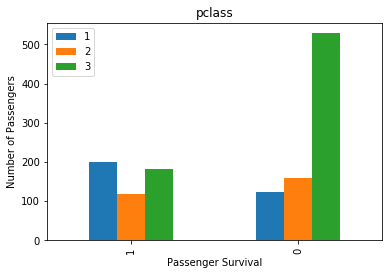

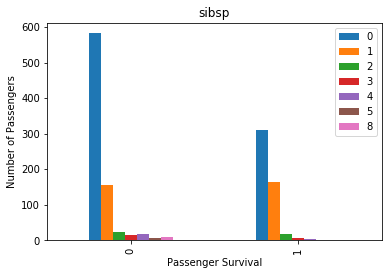

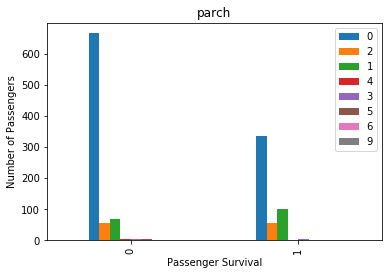

In [17]:
def analyse_discrete(df, var):
    df = df.copy()
    labels = data[var].unique()
    counts = pd.DataFrame(columns=labels)
    for label in labels:
        counts[label] = df[df[var] == label][target].value_counts()
    counts.plot(kind='bar', stacked=False, title=var)
    plt.ylabel('Number of Passengers')
    plt.xlabel('Passenger Survival')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(data, var)

Distribution is not very even! Some classes are over-represented.

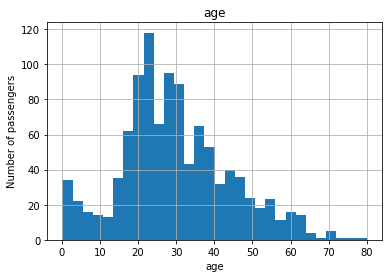

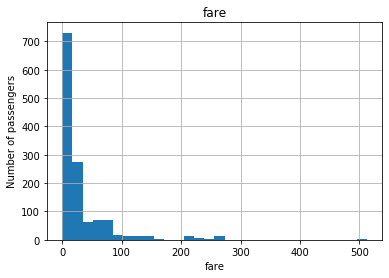

In [18]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of passengers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

for var in continuous_vars:
    analyse_continuous(data, var)

Age has an ok distribution, but fare does not - it will require a log transform.

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1),  # predictors
    data[target],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [20]:
def strip_cabin_number(cabin):
    if cabin is not np.nan:
        return str(cabin)[0]
    return cabin

X_train['cabin'] = X_train['cabin'].apply(lambda row: strip_cabin_number(row))
X_test['cabin'] = X_test['cabin'].apply(lambda row: strip_cabin_number(row))
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [21]:
def replace_missing_numericals(df, var_list):
    for var in var_list:
        mode_val = df[var].mode()[0]
        print('mode of {}: {}'.format(var, mode_val))

        # add boolean feature
        feat_name = var + '_missing'
        df[feat_name] = df[var].isnull().astype(int)
        features.append(feat_name)

        # fill original feature with mode
        df[var] = df[var].fillna(mode_val)
    return df    
    
X_train = replace_missing_numericals(X_train, vars_num_with_na)
X_test = replace_missing_numericals(X_test, vars_num_with_na)

X_train.head()

mode of age: 24.0
mode of fare: 7.75
mode of age: 22.0
mode of fare: 8.05


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_missing,fare_missing
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,24.0,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,NaN,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [22]:
X_train[vars_cat_with_na] = X_train[vars_cat_with_na].fillna('Missing')
X_test[vars_cat_with_na] = X_test[vars_cat_with_na].fillna('Missing')

# check how many we replaced
for var in vars_cat_with_na:
    trn = X_train[var].value_counts()
    tst = X_test[var].value_counts()
    print(var + ' trn: ' + str(trn.loc['Missing']) if 'Missing' in trn.index.values else var + ' trn: ' + '0')
    print(var + ' tst: ' + str(tst.loc['Missing']) if 'Missing' in tst.index.values else var + ' tst: ' + '0')

cabin trn: 803
cabin tst: 211
embarked trn: 2
embarked tst: 0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [23]:
def find_frequent_labels(df, var, rare_perc):
    percentages = df[var].value_counts() / len(df)
    return percentages[percentages > rare_perc].index.values

for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

sex ['male' 'female']

cabin ['Missing' 'C']

embarked ['S' 'C' 'Q']

title ['Mr' 'Miss' 'Mrs']



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [24]:
encoders = []
for var in vars_cat:
    encoder = LabelEncoder()
    X_train[var] = encoder.fit_transform(X_train[var])
    X_test[var] = encoder.transform(X_test[var])
    
    print(var, encoder.classes_)
    encoders.append({var: encoder})

sex ['female' 'male']
cabin ['C' 'Missing' 'Rare']
embarked ['C' 'Q' 'Rare' 'S']
title ['Miss' 'Mr' 'Mrs' 'Rare']


In [25]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_missing,fare_missing
1118,3,1,25.0,0,0,7.9250,1,3,1,0,0
44,1,0,41.0,0,0,134.5000,2,0,0,0,0
1072,3,1,24.0,0,0,7.7333,1,1,1,1,0
1130,3,0,18.0,0,0,7.7750,1,3,0,0,0
574,2,1,29.0,1,0,21.0000,1,3,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [26]:
scaler = MinMaxScaler()
scaler.fit(X_train[features])

X_train = scaler.transform(X_train[features])
X_test = scaler.transform(X_test[features])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [29]:
regularization = 1 - 0.0005
lin_model = LogisticRegression(C=regularization, random_state=0)
lin_model.fit(X_train, y_train)
joblib.dump(lin_model, 'titanic_lasso_regression.pkl')

['titanic_lasso_regression.pkl']

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [36]:
# make predictions for train set
train_pred = lin_model.predict(X_train)
test_pred = lin_model.predict(X_test)

train_roc = roc_auc_score(y_train, train_pred)
test_roc = roc_auc_score(y_test, test_pred)

print('training area under ROC:', train_roc)
print('testing area under ROC:', test_roc)

train_binary_pred = np.clip(train_pred, 0, 1)
test_binary_pred = np.clip(test_pred, 0, 1)

train_acc = accuracy_score(y_train, train_binary_pred)
test_acc = accuracy_score(y_test, test_binary_pred)

print('training accuracy: ', train_acc)
print('testing accuracy: ', test_acc)

training area under ROC: 0.7902666151468315
testing area under ROC: 0.7594444444444444
training accuracy:  0.8080229226361032
testing accuracy:  0.7900763358778626


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**